<a href="https://colab.research.google.com/github/Ajitesh-Shukla/Ajitesh-Shukla.github.io/blob/main/ME_599_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
'''Implement Variational Autoencoder'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
from torch.utils.data import Dataset, DataLoader, random_split
import glob
import numpy as np
import os
from google.colab.patches import cv2_imshow
from torchvision import transforms
import cv2
from tqdm import tqdm
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [126]:
'''NN parameters'''
lr=0.001
bs=64
epochs=100
device=torch.device('cpu')

In [119]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: False


In [120]:
'''Implement Dataloader for MNSIT dataset'''
# Transforms, just as before
transform = transforms.Compose([transforms.ToTensor()])
# ,
                                # transforms.Normalize(torch.tensor([0.13]),
                                #                      torch.tensor([0.31]))])

# download dataset
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


In [121]:
'''Try visualizing mnsit dataset'''
inverse_transform = transforms.Compose([
    # transforms.Normalize(
    #     mean=[-0.13 / 0.31],
    #     std=[1 / 0.31]
    # ),
    transforms.ToPILImage()
])
for x in train_loader:
      for i in range(10):
          img=inverse_transform(x[0][i, :, :, :])
          open_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
          cv2_imshow(open_cv)
      break


In [122]:
'''Weight Initialization for VAE'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

In [123]:
class VAE_mnsit(nn.Module):

    def __init__(self, in_dim=784, hidden_dim_1=392, hidden_dim_2=196, device=device):
        super(VAE_mnsit, self).__init__()

        # encoding network
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1,hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2,hidden_dim_2),
            nn.ReLU()
            )

        # VAE parametrization
        self.mean = nn.Linear(hidden_dim_2, 2)
        self.logvar = nn.Linear(hidden_dim_2, 2)

        # Decoding Network
        self.decoder = nn.Sequential(
            nn.Linear(2, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, in_dim),
            nn.Sigmoid()   # BCE loss needs targets b/w 0 and 1, thus Sigmoid
            )

        # Weight initialization
        self.apply(weights_init)

    def encode(self, x):   # To get mean and logarithm of variance
        x = self.encoder(x)
        mean, logvar = self.mean(x), self.logvar(x)
        return mean, logvar

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        var=torch.exp(0.5 * log_var)   # S.D. is sqrt variance
        eps = torch.randn_like(var).to(device)
        z = mean + var*eps
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [124]:
def loss_calc(x, y, mean, log_var):
    reprojection_loss = nn.functional.binary_cross_entropy(y, x, reduction='sum')     # Observed that MSE loss is bad, anyways the input is 0/1, crossentropy is better
    kl_div = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reprojection_loss + kl_div

In [127]:
'''Training pipeline for mnsit dataset'''
model_mnsit=VAE_mnsit().to(device)
optimizer = torch.optim.Adam(model_mnsit.parameters(), lr=lr)

model_mnsit.train()
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):

        x = x.view(-1, 784).to(device)

        optimizer.zero_grad()

        x_tilde, mean, log_var = model_mnsit(x)

        loss=loss_calc(x, x_tilde, mean, log_var)
        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
print(overall_loss)

	Epoch 1 	Average Loss:  177.02342609254885
	Epoch 2 	Average Loss:  158.43847628565965
	Epoch 3 	Average Loss:  153.68754238100163
	Epoch 4 	Average Loss:  150.00141940121972
	Epoch 5 	Average Loss:  147.2248446730183
	Epoch 6 	Average Loss:  146.2212642722603
	Epoch 7 	Average Loss:  145.69926638282604
	Epoch 8 	Average Loss:  144.2708271152818
	Epoch 9 	Average Loss:  144.9113939380951
	Epoch 10 	Average Loss:  144.55347555805804
	Epoch 11 	Average Loss:  143.05149267271972
	Epoch 12 	Average Loss:  142.32873480195298
	Epoch 13 	Average Loss:  142.58054232928134
	Epoch 14 	Average Loss:  142.77830445117604
	Epoch 15 	Average Loss:  142.34116555685168
	Epoch 16 	Average Loss:  141.3926873710901
	Epoch 17 	Average Loss:  141.46363688075047
	Epoch 18 	Average Loss:  141.73937404473793
	Epoch 19 	Average Loss:  141.49123207507546
	Epoch 20 	Average Loss:  141.61741121143515
	Epoch 21 	Average Loss:  140.60201550853162
	Epoch 22 	Average Loss:  141.74361098868616
	Epoch 23 	Average Loss:

In [128]:
'''Testing, visualization'''
with torch.no_grad():
    for i, (x, num) in enumerate(test_loader):
        x=x.view(-1, 784)
        if i<1:
            x_tilde, mean, log_var =model_mnsit(x.to(device))
            for j in range(10):
                # print('element is: ', num[j].item(), 'mean is: ', mean[j, :].numpy(), 'log variance is: ', log_var[j, :].numpy())
                image = inverse_transform(x[j, :].view(1, 28, 28))

                open_cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

                output_image = inverse_transform(x_tilde[j, :].view(1, 28, 28))
                open_cv_output_image = cv2.cvtColor(np.array(output_image), cv2.COLOR_RGB2BGR)
                cv2_imshow(np.concatenate((open_cv_image, open_cv_output_image), axis=1 ))
            break

**Study results further to see if any intution is valid**

In [129]:
'''Get the mean of all means obtained for particular indexes'''
dict_all={}
dict_var={}
data_points={}
for i in range(10):
    dict_all[i]=[]
    dict_var[i]=[]
    data_points[i]={}
with torch.no_grad():
    for i, (x, num) in enumerate(train_loader):
        x=x.view(-1, 784)
        x_tilde, mean, log_var =model_mnsit(x.to(device))
        for j in range(x.size(0)):
            dict_all[num[j].item()].append(mean[j, :].numpy())
            dict_var[num[j].item()].append(torch.exp(0.5 * log_var[j, :]).numpy())

for key in dict_all.keys():
    data_points[key]['mean']=np.mean(np.array(dict_all[key]), axis=0)
    data_points[key]['covariance']=np.cov(np.array(dict_all[key]), rowvar=False)


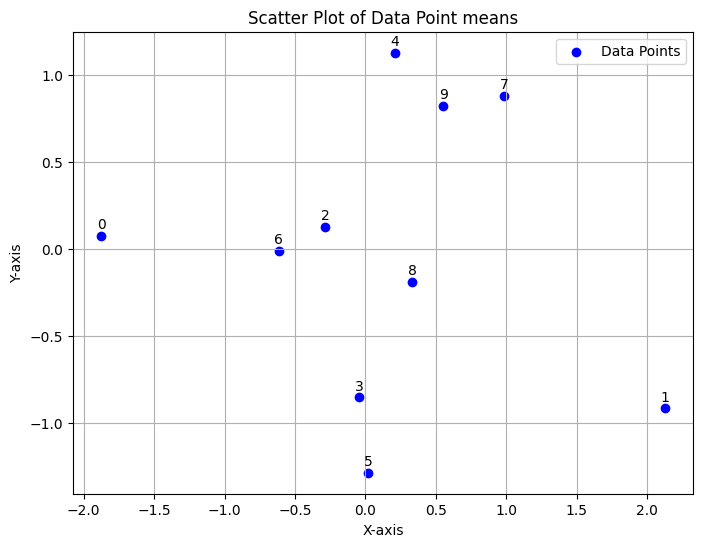

In [130]:
'''Plottig means'''
x_coords, y_coords = [], []
for key in data_points.keys():
    x_coords.append(data_points[key]['mean'][0])
    y_coords.append(data_points[key]['mean'][1])

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, marker='o', color='blue', label='Data Points')

# Annotate points with their indices
for idx, point in data_points.items():
    plt.annotate(str(idx), (point['mean'][0], point['mean'][1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Data Point means')
plt.grid(True)
plt.legend()
plt.show()

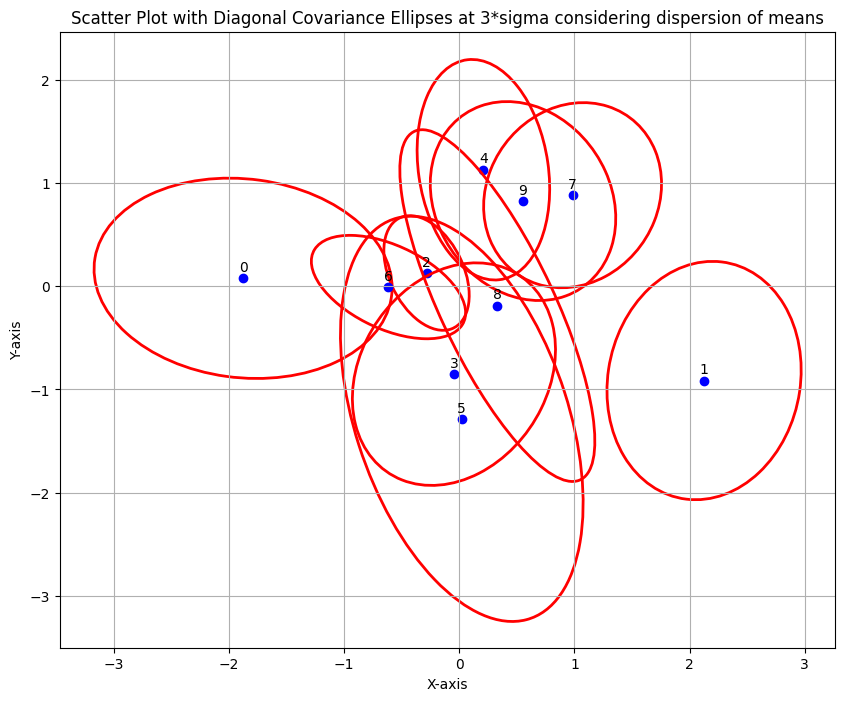

In [131]:
'''Plotting variance with 3 sigma belts'''
plt.figure(figsize=(10, 8))

for idx, point_info in data_points.items():
    mean = point_info['mean']
    covariance = point_info['covariance']

    # Scatter plot for the numbers
    plt.scatter(mean[0], mean[1], marker='o', color='blue', label=f'{idx}')

    # Create ellipse using eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    ellipse = Ellipse(xy=mean, width=np.sqrt(eigenvalues[0]) * 3, height=np.sqrt(eigenvalues[1]) * 3,
                      angle=angle, edgecolor='red', fc='none', lw=2)
    plt.gca().add_patch(ellipse)

    # Annotate points with their indices
    plt.annotate(str(idx), (mean[0], mean[1]), textcoords="offset points", xytext=(0, 5), ha='center')

# Adding labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with Diagonal Covariance Ellipses at 3*sigma considering dispersion of means')
plt.grid(True)
plt.show()


 **Stretch: VAE implementation for real cat and dog images using convolutional NNs, gave poor results**
 :

In [132]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
'''Implement Dataset class for Cat Dog dataset, which must have a len, and getitem function'''
class VAEdataset_train(Dataset):
    def __init__(self, transform=None):
        self.imgs_path = "/content/drive/MyDrive/ME599_project/PetImages/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            print(class_path)
            class_name = class_path.split("/")[-1]     # Dog or cat
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        self.class_map = {"Dog" : 0, "Cat": 1}
        self.img_dim = (256, 256)
        self.transform=transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        try:
            X = cv2.resize(img, self.img_dim)
        except:
            X=np.zeros((self.img_dim[0], self.img_dim[1], 3)).astype('uint8')
        class_id = self.class_map[class_name]
        class_id = torch.tensor([class_id])
        if self.transform:
            X=self.transform(X)
        return X


In [134]:
'''Create Dataloaders for Cat Dog dataset, might be too slow due to GPU '''

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]),
                                                     torch.tensor([0.229, 0.224, 0.225]))]) # Got this value from discussions on ImageNet dataset

all_data=VAEdataset_train(transform=transform)
tot_len=all_data.__len__()
train_len=int(0.9*tot_len)
test_len=tot_len-train_len
train_data, test_data = random_split(all_data, [train_len, test_len])
train_loader=DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader=DataLoader(test_data, batch_size=bs, shuffle=True)


/content/drive/MyDrive/ME599_project/PetImages/Cat
/content/drive/MyDrive/ME599_project/PetImages/Dog


In [144]:
'''VAE for cat dog dataset Architecture'''
class VAE(nn.Module):
    def __init__(self, input_dim, output_dim, dim, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, 2*dim, 4, 2, 1),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(True),
            nn.Conv2d(2*dim, 2*dim, 5, 1, 0),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(True),
            nn.Conv2d(2*dim, z_dim * 2, 3, 1, 0),
            nn.BatchNorm2d(z_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, dim, 3, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, 2*dim, 5, 1, 0),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(2*dim, 2*dim, 4, 2, 1),
            nn.BatchNorm2d(2*dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(2*dim, output_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim=1)   # Splits into two
        q_z_x = Normal(mu, logvar.mul(.5).exp())
        p_z = Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        kl_div = kl_divergence(q_z_x, p_z).sum(1).mean()

        x_tilde = self.decoder(q_z_x.rsample())    # resample is just a part of the reparaetrization trick, can backpropagate from this
        return x_tilde, kl_div

**Directly move to next block, that uses trained weights**

In [15]:
'''Training pipeline for cat dog dataset'''
'''Model, optimizer'''
model=VAE(3, 3, 32, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if os.path.isfile('/content/drive/MyDrive/ME599_project/model.pth'):
    model.load_state_dict('/content/drive/MyDrive/ME599_project/model.pth')
    optimizer.load_state_dict('/content/drive/MyDrive/ME599_project/optim.pth')

    training_history=torch.load('/content/drive/MyDrive/ME599_project/training_history.pth')

else:
    training_history={'last_ep': 0, 'train_loss': [], 'val_loss': [], 'best_loss': 100.0}

start_ep=training_history['last_ep']


'''Training'''
train_loss=[]
test_loss=[]
for epoch in range(start_ep, epochs):
    optimizer.zero_grad()
    train_loss_=[]
    test_loss_=[]
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, x in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            x_tilde, kl_div =model(x.to(device))
            reconst_loss=F.mse_loss(x_tilde.to(device), x.to(device))
            loss=reconst_loss.to(device)+kl_div
            train_loss_.append(loss.detach().cpu().numpy())    # I think this resolved the slow training issue
            loss.backward()
            optimizer.step()
    training_history['train_loss'].append(np.mean(np.array(train_loss_)))
    training_history['last_ep']=i
    print('train loss for epoch {}: '.format(epoch), np.mean(np.array(train_loss_)))

    '''Eval'''
    if epoch%5==0:
        with torch.no_grad():
            for x in test_loader:
                x_tilde, kl_div =model(x.to(device))
                reconst_loss=F.mse_loss(x_tilde.to(device), x.to(device))
                loss_test=(reconst_loss+kl_div).to(device)
                test_loss_.append(loss_test.detach().cpu().numpy())
        training_history['val_loss'].append(np.mean(np.array(test_loss_)))
        print('test loss for epoch {}: '.format(epoch), np.mean(np.array(test_loss_)))

        if np.mean(np.array(test_loss_))<0.99*training_history['best_loss']:
            torch.save(model.state_dict(), '/content/drive/MyDrive/ME599_project/model.pth')
            torch.save(optimizer.state_dict(), '/content/drive/MyDrive/ME599_project/optim.pth')
            training_history['best_loss']=np.mean(np.array(test_loss_))
            torch.save(training_history, '/content/drive/MyDrive/ME599_project/training_history.pth')

        else:
            continue



NameError: ignored

0


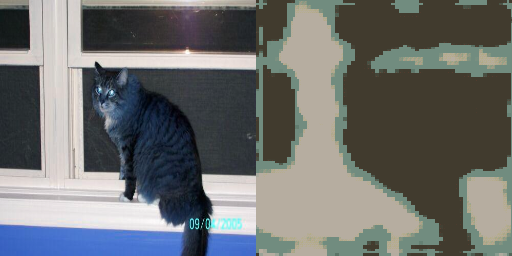

1


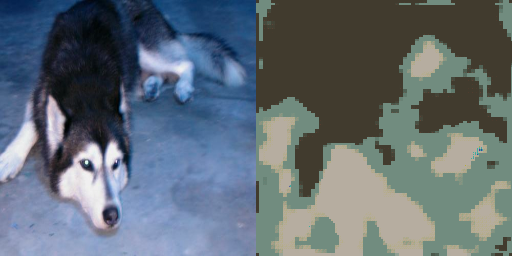

2


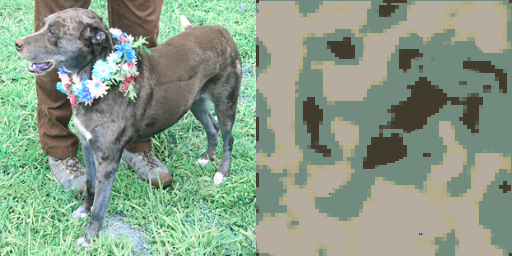

3


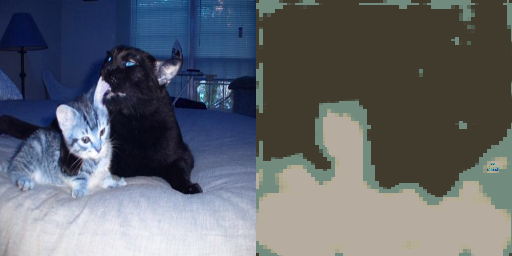

4


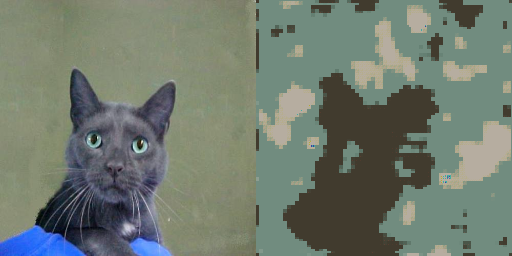

5


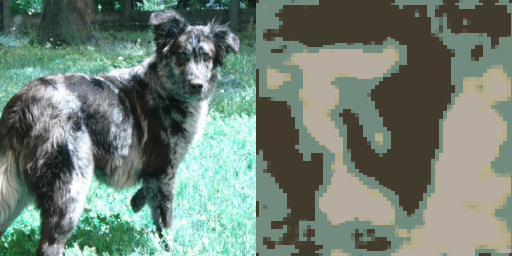

6


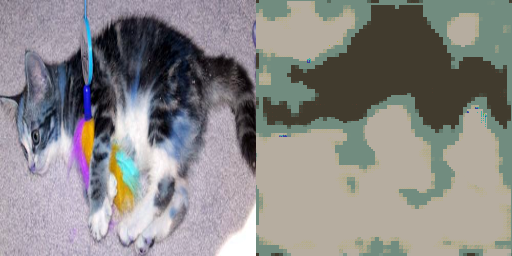

7


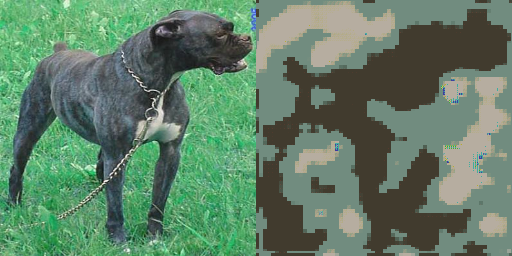

8


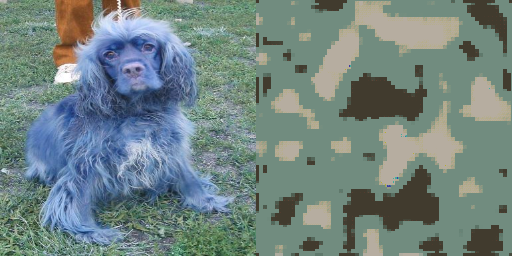

9


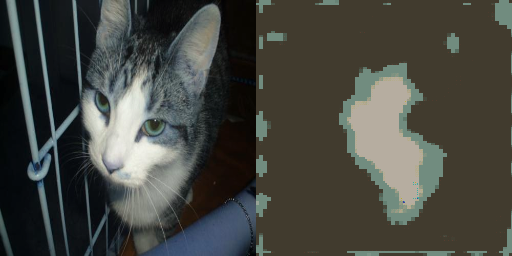

In [145]:
'''Testing Pipeline for  cat dog dataset'''
model=VAE(3, 3, 32, 10).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/ME599_project/model.pth', map_location=torch.device('cpu')))
training_history=torch.load('/content/drive/MyDrive/ME599_project/training_history.pth')

'''Inverse transform to visualize'''
inverse_transform = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                                transforms.ToPILImage()
                               ])


with torch.no_grad():
    for i, x in enumerate(train_loader):
        if i<1:
            x_tilde, _ =model(x.to(device))
            for j in range(10):
                print(j)
                reversed_image_o = inverse_transform(x[j, :, :, :].squeeze())
                open_cv_image_o = cv2.cvtColor(np.array(reversed_image_o), cv2.COLOR_RGB2BGR)

                reversed_image = inverse_transform(x_tilde[j, :, :, :].squeeze())
                open_cv_image = cv2.cvtColor(np.array(reversed_image), cv2.COLOR_RGB2BGR)
                cv2_imshow(np.concatenate((open_cv_image_o, open_cv_image), axis=1 ))
            break
